In [1]:
# ==============================================================================
# IMPORTS
# ==============================================================================
import numpy as np
import pandas as pd
import pandas_ta_classic as ta
import matplotlib.pyplot as plt
import seaborn as sns
import csv
from pathlib import Path
import os
import warnings
import time
warnings.filterwarnings('ignore')

import yfinance as yf
from pandas_datareader import data as pdr
import gymnasium as gym
from gymnasium import spaces
from stable_baselines3 import SAC
from stable_baselines3.common.vec_env import DummyVecEnv
import torch
import torch.nn as nn

print(f"PyTorch: {torch.__version__}")
DEVICE = "mps" if torch.backends.mps.is_available() else "cpu"
print(f"Device: {DEVICE}")
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)
print("\n Imports complete")

PyTorch: 2.9.1
Device: mps

 Imports complete


In [2]:
# ==============================================================================
# V5 CONFIG - PURE SORTINO (WORKING VERSION)
# ==============================================================================


# Training
CV_TIMESTEPS = 200000
FINAL_TIMESTEPS = 750000


# Data periods
DATA_START = '2010-01-01'
DATA_END = '2025-12-10'
TRAIN_END = '2021-12-31'
PURGE_DAYS = 10

# OOS Test periods
OOS_PERIODS = {
    '2022': ('2022-01-01', '2022-12-31'),
    '2023': ('2023-01-01', '2023-12-31'),
    '2024': ('2024-01-01', '2024-12-31'),
    '2025': ('2025-01-01', '2025-12-10'),
}

# Risk parameters
STOP_LOSS_PCT = 0.12
TRAILING_STOP_PCT = 0.13
MAX_DRAWDOWN_PCT = 0.25
TRANSACTION_COST = 0.0001

# Trend filter
TREND_FILTER_BUFFER = 0.95

# Window
WINDOW_SIZE = 10
INITIAL_CAPITAL = 1000000

# Save paths
SAVE_PATH = os.path.expanduser('~/Desktop/spy_sac_v5/')
TRADES_PATH = os.path.join(SAVE_PATH, 'trades/')
MODELS_PATH = os.path.join(SAVE_PATH, 'models/')
RESULTS_PATH = os.path.join(SAVE_PATH, 'results/')
CHARTS_PATH = os.path.join(SAVE_PATH, 'charts/')

for path in [SAVE_PATH, TRADES_PATH, MODELS_PATH, RESULTS_PATH, CHARTS_PATH]:
    os.makedirs(path, exist_ok=True)

print("V5 CONFIG")
print("="*60)

V5 CONFIG


In [3]:
# ==============================================================================
# DATA DOWNLOAD
# ==============================================================================
print("Downloading data (2010-2025)...")
start_time = time.time()

spy = yf.download('SPY', start=DATA_START, end=DATA_END, progress=False)
sh = yf.download('SH', start=DATA_START, end=DATA_END, progress=False)
vix = yf.download('^VIX', start=DATA_START, end=DATA_END, progress=False)

# Flatten MultiIndex
if isinstance(spy.columns, pd.MultiIndex): spy.columns = spy.columns.get_level_values(0)
if isinstance(sh.columns, pd.MultiIndex): sh.columns = sh.columns.get_level_values(0)
if isinstance(vix.columns, pd.MultiIndex): vix.columns = vix.columns.get_level_values(0)

# Treasury yields
dgs10 = pdr.DataReader('DGS10', 'fred', DATA_START, DATA_END).reindex(spy.index, method='ffill')
dgs3mo = pdr.DataReader('DGS3MO', 'fred', DATA_START, DATA_END).reindex(spy.index, method='ffill')

print(f" SPY: {len(spy)} days")
print(f" SH: {len(sh)} days")
print(f" VIX: {len(vix)} days")
print(f" Download time: {time.time()-start_time:.1f}s")

YF.download() has changed argument auto_adjust default to True
 SPY: 4009 days
 SH: 4009 days
 VIX: 4009 days
 Download time: 1.0s


Data: 2010-01-04 to 2025-12-09 (4009 days)


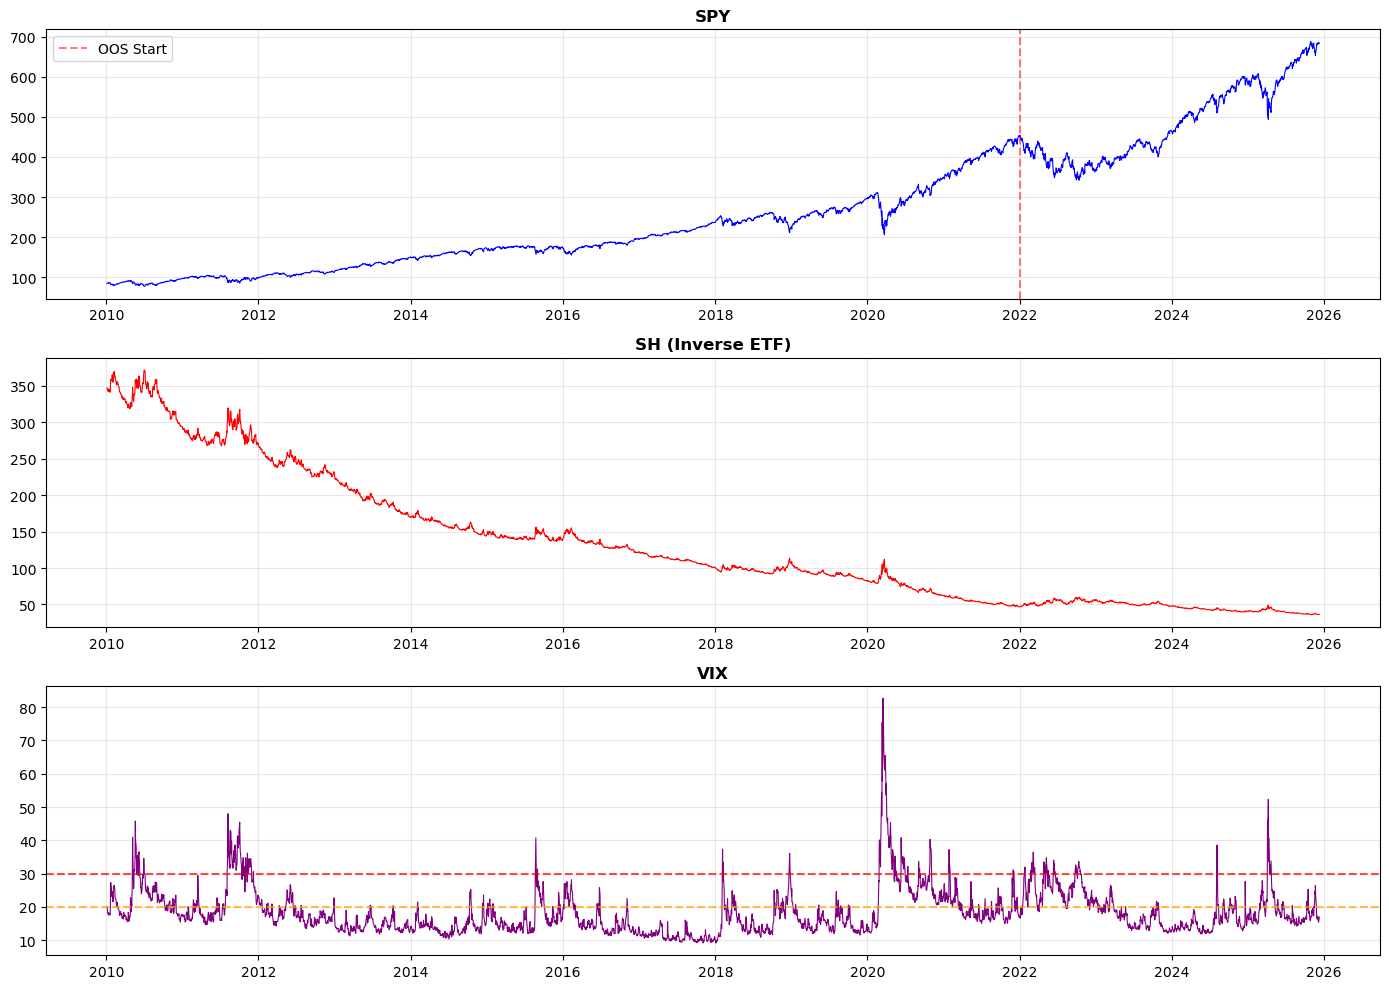

 Saved: /Users/ak/Desktop/spy_sac_v5/charts/1_data_overview.png


In [4]:
# ==============================================================================
# DATA EXPLORATION
# ==============================================================================
explore_df = pd.DataFrame({'SPY': spy['Close'], 'SH': sh['Close'], 'VIX': vix['Close']}).dropna()
print(f"Data: {explore_df.index[0].strftime('%Y-%m-%d')} to {explore_df.index[-1].strftime('%Y-%m-%d')} ({len(explore_df)} days)")

fig, axes = plt.subplots(3, 1, figsize=(14, 10))
axes[0].plot(explore_df.index, explore_df['SPY'], 'b-', lw=0.8)
axes[0].axvline(pd.Timestamp('2022-01-01'), color='red', ls='--', alpha=0.5, label='OOS Start')
axes[0].set_title('SPY', fontweight='bold'); axes[0].legend(); axes[0].grid(alpha=0.3)

axes[1].plot(explore_df.index, explore_df['SH'], 'r-', lw=0.8)
axes[1].set_title('SH (Inverse ETF)', fontweight='bold'); axes[1].grid(alpha=0.3)

axes[2].plot(explore_df.index, explore_df['VIX'], 'purple', lw=0.8)
axes[2].axhline(20, color='orange', ls='--', alpha=0.7); axes[2].axhline(30, color='red', ls='--', alpha=0.7)
axes[2].set_title('VIX', fontweight='bold'); axes[2].grid(alpha=0.3)

plt.tight_layout()
plt.savefig(f"{CHARTS_PATH}1_data_overview.png", dpi=150)
plt.show()
print(f" Saved: {CHARTS_PATH}1_data_overview.png")

In [5]:
# ==============================================================================
# FEATURE ENGINEERING V4 (pandas-ta)
# ==============================================================================
print("Computing features...")
data = spy.copy()
data['SH_Close'] = sh['Close']
data['VIX'] = vix['Close']
data['YCS'] = dgs10['DGS10'] - dgs3mo['DGS3MO']
data = data.dropna()

def compute_features(df):
    df = df.copy()
    close = df['Close']
    high, low = df['High'], df['Low']
    vix = df['VIX']
    ycs = df['YCS']
    
    # ═══════════════════════════════════════════════════════════
    # FAST FEATURES (new)
    # ═══════════════════════════════════════════════════════════
    
    # RSI (14) - oversold bounces
    rsi = ta.rsi(close, length=14)
    df['rsi_14_z'] = (rsi - rsi.rolling(60).mean()) / (rsi.rolling(60).std() + 1e-8)
    
    # MACD histogram - momentum shift
    macd_df = ta.macd(close, fast=12, slow=26, signal=9)
    macd_hist = macd_df['MACDh_12_26_9']
    df['macd_hist_z'] = (macd_hist - macd_hist.rolling(60).mean()) / (macd_hist.rolling(60).std() + 1e-8)
    
    # Bollinger %B - price vs bands
    bbands = ta.bbands(close, length=20, std=2)
    bb_pct = bbands['BBP_20_2.0']
    df['bb_pct_z'] = (bb_pct - bb_pct.rolling(60).mean()) / (bb_pct.rolling(60).std() + 1e-8)
    
    # ATR (14) - fast volatility
    atr = ta.atr(high, low, close, length=14)
    df['atr_14_z'] = (atr - atr.rolling(60).mean()) / (atr.rolling(60).std() + 1e-8)
    
    # ═══════════════════════════════════════════════════════════
    # MEDIUM FEATURES (keep)
    # ═══════════════════════════════════════════════════════════
    
    # Efficiency Ratio (10)
    er = ta.er(close, length=10)
    df['er_10_z'] = (er - er.rolling(60).mean()) / (er.rolling(60).std() + 1e-8)
    
    # Risk-adjusted momentum (20)
    mom = close.pct_change(20)
    vol20 = close.pct_change().rolling(20).std()
    ram = mom / (vol20 + 1e-8)
    df['ram_20_z'] = (ram - ram.rolling(60).mean()) / (ram.rolling(60).std() + 1e-8)
    
    # ═══════════════════════════════════════════════════════════
    # SLOW FEATURES (keep)
    # ═══════════════════════════════════════════════════════════
    
    # VIX regime
    df['vix_z'] = (vix - vix.rolling(60).mean()) / (vix.rolling(60).std() + 1e-8)
    
    # Yield curve spread
    df['ycs_z'] = (ycs - ycs.rolling(60).mean()) / (ycs.rolling(60).std() + 1e-8)
    
    # ═══════════════════════════════════════════════════════════
    # TREND & PRICES
    # ═══════════════════════════════════════════════════════════
    df['MA50'] = ta.sma(close, length=50)
    df['MA200'] = ta.sma(close, length=200)
    df['Close_orig'] = close
    df['SH_orig'] = df['SH_Close']
    df['VIX_raw'] = vix
    
    return df.dropna()

featured_data = compute_features(data)

# Updated feature list (8 features)
MARKET_FEATURES = [
    'rsi_14_z',      # Fast
    'macd_hist_z',   # Fast
    'bb_pct_z',      # Fast
    'atr_14_z',      # Fast
    'er_10_z',       # Medium
    'ram_20_z',      # Medium
    'vix_z',         # Slow
    'ycs_z',         # Slow
]

print(f" Features: {len(MARKET_FEATURES)} indicators, {len(featured_data)} days")
print(f" Date range: {featured_data.index[0].strftime('%Y-%m-%d')} to {featured_data.index[-1].strftime('%Y-%m-%d')}")

Computing features...
 Features: 8 indicators, 3780 days
 Date range: 2010-10-19 to 2025-12-09


In [6]:
# ==============================================================================
# ENVIRONMENT V5 - DIFFERENTIAL SHARPE RATIO REWARD
# ==============================================================================
class SPYSACEnvV5(gym.Env):
    metadata = {"render_modes": ["human"]}
    
    def __init__(self, X, prices_spy, prices_sh, vix, ma50, ma200, dates=None, window_size=10, initial_capital=1_000_000, log_trades=False):
        super().__init__()
        self.X, self.prices_spy, self.prices_sh = X, prices_spy, prices_sh
        self.vix, self.ma50, self.ma200 = vix, ma50, ma200
        self.dates, self.window_size, self.initial_capital = dates, window_size, initial_capital
        self.log_trades = log_trades
        self.action_space = spaces.Box(low=-1.0, high=2.0, shape=(1,), dtype=np.float32)
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(window_size * len(MARKET_FEATURES) + 2,), dtype=np.float32)
        self.reset()

    def _get_regime_params(self):
        v = self.vix[self.current_step]
        if v < 15: return 1.75, STOP_LOSS_PCT * 0.8, TRAILING_STOP_PCT * 0.8
        if v < 20: return 1.40, STOP_LOSS_PCT * 0.9, TRAILING_STOP_PCT * 0.9
        if v < 25: return 1.00, STOP_LOSS_PCT, TRAILING_STOP_PCT
        if v < 35: return 0.50, STOP_LOSS_PCT * 1.3, TRAILING_STOP_PCT * 1.2
        return 0.25, STOP_LOSS_PCT * 1.5, TRAILING_STOP_PCT * 1.3

    def _get_trend_weight(self):
        ma50 = self.ma50[self.current_step]
        ma200 = self.ma200[self.current_step]
        trend_pct = (ma50 - ma200) / (ma200 + 1e-8)
        if trend_pct >= 0:
            return 1.0
        else:
            return max(0.40, 1.0 + (trend_pct * 6.0))

    def _get_short_weight(self):
        ma50 = self.ma50[self.current_step]
        ma200 = self.ma200[self.current_step]
        trend_pct = (ma50 - ma200) / (ma200 + 1e-8)
        if trend_pct >= 0:
            return 0.1
        else:
            return min(0.5, 0.1 + abs(trend_pct) * 8)

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.current_step = self.window_size
        self.cash = self.initial_capital
        self.spy_shares = self.sh_shares = 0.0
        self.entry_price_spy = self.entry_price_sh = self.highest_price = 0.0
        self.peak_value = self.initial_capital
        self.portfolio_history = [self.initial_capital]
        self.returns_history = []
        self.circuit_breaker = False
        self.trade_log = []
        # DSR state variables
        self._A = 0.0       # EMA of returns
        self._B = 0.0001    # EMA of squared returns
        return self._get_obs(), {}

    def _get_portfolio_value(self):
        return self.cash + self.spy_shares * self.prices_spy[self.current_step] + self.sh_shares * self.prices_sh[self.current_step]

    def _get_exposure(self):
        pv = self._get_portfolio_value()
        if pv <= 0: return 0.0
        return (self.spy_shares * self.prices_spy[self.current_step] - self.sh_shares * self.prices_sh[self.current_step]) / pv

    def _get_obs(self):
        start = max(0, self.current_step - self.window_size)
        window = self.X[start:self.current_step]
        if len(window) < self.window_size:
            window = np.vstack([np.zeros((self.window_size - len(window), len(MARKET_FEATURES))), window])
        pv = self._get_portfolio_value()
        return np.concatenate([window.flatten(), [self._get_exposure(), self.cash / pv if pv > 0 else 1.0]]).astype(np.float32)

    def _close_all_positions(self):
        if self.spy_shares > 0:
            self.cash += self.spy_shares * self.prices_spy[self.current_step] * (1 - TRANSACTION_COST)
            self.spy_shares = self.entry_price_spy = 0.0
        if self.sh_shares > 0:
            self.cash += self.sh_shares * self.prices_sh[self.current_step] * (1 - TRANSACTION_COST)
            self.sh_shares = self.entry_price_sh = 0.0

    def _execute_trade(self, target_exp, max_pos):
        spy_p, sh_p = self.prices_spy[self.current_step], self.prices_sh[self.current_step]
        pv = self._get_portfolio_value()
        if target_exp > 0: 
            target_exp = min(target_exp, max_pos)
        elif target_exp < 0: 
            short_limit = self._get_short_weight()
            target_exp = max(target_exp, -short_limit)
        curr_exp = self._get_exposure()
        if (curr_exp > 0.1 and target_exp < -0.1) or (curr_exp < -0.1 and target_exp > 0.1):
            self._close_all_positions()
            pv = self.cash
        if target_exp > 0.05:
            if self.sh_shares > 0: 
                self.cash += self.sh_shares * sh_p * (1 - TRANSACTION_COST)
                self.sh_shares = self.entry_price_sh = 0.0
                pv = self._get_portfolio_value()
            delta = target_exp * pv - self.spy_shares * spy_p
            if delta > 100 and self.cash > 100:
                amt = min(delta, self.cash * 0.99)
                self.spy_shares += amt * (1 - TRANSACTION_COST) / spy_p
                self.cash -= amt
                if self.entry_price_spy == 0: 
                    self.entry_price_spy = self.highest_price = spy_p
            elif delta < -100 and self.spy_shares > 0:
                sell = min(abs(delta) / spy_p, self.spy_shares)
                self.cash += sell * spy_p * (1 - TRANSACTION_COST)
                self.spy_shares -= sell
        elif target_exp < -0.05:
            if self.spy_shares > 0: 
                self.cash += self.spy_shares * spy_p * (1 - TRANSACTION_COST)
                self.spy_shares = self.entry_price_spy = 0.0
                pv = self._get_portfolio_value()
            delta = abs(target_exp) * pv - self.sh_shares * sh_p
            if delta > 100 and self.cash > 100:
                amt = min(delta, self.cash * 0.99)
                self.sh_shares += amt * (1 - TRANSACTION_COST) / sh_p
                self.cash -= amt
                if self.entry_price_sh == 0: 
                    self.entry_price_sh = sh_p
            elif delta < -100 and self.sh_shares > 0:
                sell = min(abs(delta) / sh_p, self.sh_shares)
                self.cash += sell * sh_p * (1 - TRANSACTION_COST)
                self.sh_shares -= sell
        else: 
            self._close_all_positions()

    def _check_stop_losses(self, sl, ts):
        spy_p, sh_p = self.prices_spy[self.current_step], self.prices_sh[self.current_step]
        if self.spy_shares > 0 and self.entry_price_spy > 0:
            self.highest_price = max(self.highest_price, spy_p)
            if (self.entry_price_spy - spy_p) / self.entry_price_spy >= sl or (self.highest_price - spy_p) / self.highest_price >= ts:
                self.cash += self.spy_shares * spy_p * (1 - TRANSACTION_COST)
                self.spy_shares = self.entry_price_spy = 0.0
                return True
        if self.sh_shares > 0 and self.entry_price_sh > 0:
            if (self.entry_price_sh - sh_p) / self.entry_price_sh >= sl:
                self.cash += self.sh_shares * sh_p * (1 - TRANSACTION_COST)
                self.sh_shares = self.entry_price_sh = 0.0
                return True
        return False

    def _compute_reward(self, daily_ret):
        """
        Differential Sharpe Ratio (Moody & Saffell, 2001)
        Smooth, recursive reward signal without windowed noise.
        """
        eta = 0.04  # Decay factor (~25-day effective window)
        
        # Compute deltas
        delta_A = daily_ret - self._A
        delta_B = daily_ret**2 - self._B
        
        # Update EMAs
        self._A += eta * delta_A
        self._B += eta * delta_B
        
        # Differential Sharpe Ratio
        variance = self._B - self._A**2
        if variance < 1e-8:
            dsr = daily_ret * 100  # Fallback for early steps
        else:
            denom = variance**1.5
            dsr = (self._B * delta_A - 0.5 * self._A * delta_B) / (denom + 1e-8)
            dsr = dsr * 10  # Scale for RL
        
        return np.clip(dsr, -5.0, 5.0)

    def _log_trade(self, action, daily_ret):
        if not self.log_trades: 
            return
        pv = self._get_portfolio_value()
        spy_p, sh_p = self.prices_spy[self.current_step], self.prices_sh[self.current_step]
        self.trade_log.append({
            'date': self.dates[self.current_step] if self.dates else self.current_step,
            'action_raw': float(action), 
            'spy_pct': self.spy_shares * spy_p / pv * 100 if pv > 0 else 0,
            'sh_pct': self.sh_shares * sh_p / pv * 100 if pv > 0 else 0, 
            'cash_pct': self.cash / pv * 100 if pv > 0 else 100,
            'spy_shares': self.spy_shares, 
            'sh_shares': self.sh_shares, 
            'cash': self.cash, 
            'portfolio_value': pv,
            'daily_return_pct': daily_ret * 100, 
            'cumulative_return_pct': (pv / self.initial_capital - 1) * 100,
            'spy_price': spy_p, 
            'sh_price': sh_p, 
            'vix': self.vix[self.current_step]
        })

    def step(self, action):
        target = float(np.clip(action[0], -1.0, 2.0))
        prev_pv = self._get_portfolio_value()
        max_pos, sl, ts = self._get_regime_params()
        
        if (self.peak_value - prev_pv) / self.peak_value >= MAX_DRAWDOWN_PCT: 
            self._close_all_positions()
            self.circuit_breaker = True
        
        if not self.circuit_breaker: 
            self._check_stop_losses(sl, ts)
        
        if not self.circuit_breaker:
            if target > 0:
                trend_weight = self._get_trend_weight()
                target = min(target, max_pos * trend_weight)
            elif target < 0:
                short_weight = self._get_short_weight()
                target = max(target, -short_weight)
            self._execute_trade(target, max_pos)
        
        self.current_step += 1
        done = self.current_step >= len(self.prices_spy) - 1
        new_pv = self._get_portfolio_value()
        self.peak_value = max(self.peak_value, new_pv)
        daily_ret = (new_pv - prev_pv) / prev_pv if prev_pv > 0 else 0.0
        self.returns_history.append(daily_ret)
        self.portfolio_history.append(new_pv)
        reward = self._compute_reward(daily_ret)
        self._log_trade(action[0], daily_ret)
        info = self._compute_final_metrics() if done else {}
        return self._get_obs(), reward, done, False, info

    def _compute_final_metrics(self):
        ph, rets = np.array(self.portfolio_history), np.array(self.returns_history)
        total_ret = ph[-1] / self.initial_capital - 1
        ann_ret = (1 + total_ret) ** (252 / len(ph)) - 1 if len(ph) > 0 else 0
        max_dd = np.max((np.maximum.accumulate(ph) - ph) / (np.maximum.accumulate(ph) + 1e-8))
        sharpe = np.sqrt(252) * np.mean(rets) / (np.std(rets) + 1e-8)
        neg = rets[rets < 0]
        sortino = np.sqrt(252) * np.mean(rets) / (np.std(neg) + 1e-8) if len(neg) > 0 else 0
        calmar = ann_ret / (max_dd + 1e-8)
        win_rate = np.sum(rets > 0) / np.sum(rets != 0) * 100 if np.sum(rets != 0) > 0 else 0
        avg_win = np.mean(rets[rets > 0]) * 100 if np.sum(rets > 0) > 0 else 0
        avg_loss = np.mean(rets[rets < 0]) * 100 if np.sum(rets < 0) > 0 else 0
        pf = np.sum(rets[rets > 0]) / abs(np.sum(rets[rets < 0])) if np.sum(rets < 0) != 0 else float('inf')
        return {
            'total_return': total_ret * 100, 
            'annualized_return': ann_ret * 100, 
            'sharpe': sharpe, 
            'sortino': sortino,
            'calmar': calmar, 
            'max_drawdown': max_dd * 100, 
            'win_rate': win_rate, 
            'avg_win': avg_win, 
            'avg_loss': avg_loss,
            'profit_factor': pf, 
            'total_days': len(ph), 
            'portfolio_history': self.portfolio_history, 
            'trade_log': self.trade_log
        }


def make_env(X, spy, sh, vix, ma50, ma200, dates=None, log_trades=False):
    return lambda: SPYSACEnvV5(X, spy, sh, vix, ma50, ma200, dates, WINDOW_SIZE, INITIAL_CAPITAL, log_trades)


def evaluate(model, env):
    obs = env.reset()
    if isinstance(obs, tuple): 
        obs = obs[0]
    done = False
    while not done:
        action, _ = model.predict(obs, deterministic=True)
        step_out = env.step(action)
        if len(step_out) == 4:
            obs, _, done, info = step_out
        else:
            obs, _, done, _, info = step_out
    info = info[0] if isinstance(info, list) else info
    return info


print(" Environment V5 ready (Differential Sharpe Ratio)")

 Environment V5 ready (Differential Sharpe Ratio)


In [7]:
# ==============================================================================
# WALK-FORWARD CV
# ==============================================================================
print("\n" + "="*60 + "\nWALK-FORWARD CROSS-VALIDATION\n" + "="*60)

CV_FOLDS = [
    {'train': ('2010-01-01', '2016-12-31'), 'val': ('2017-01-01', '2018-12-31')},
    {'train': ('2010-01-01', '2018-12-31'), 'val': ('2019-01-01', '2020-12-31')},
    {'train': ('2012-01-01', '2018-12-31'), 'val': ('2019-01-01', '2020-12-31')},
    {'train': ('2012-01-01', '2020-12-31'), 'val': ('2021-01-01', '2021-12-31')},
    {'train': ('2014-01-01', '2020-12-31'), 'val': ('2021-01-01', '2021-12-31')},
]

cv_results = []
for i, fold in enumerate(CV_FOLDS):
    print(f"\n--- FOLD {i+1}/{len(CV_FOLDS)} ---")
    train_df = featured_data[fold['train'][0]:fold['train'][1]].iloc[:-PURGE_DAYS]
    val_df = featured_data[fold['val'][0]:fold['val'][1]]
    print(f"Train: {len(train_df)} days | Val: {len(val_df)} days")
    
    train_env = DummyVecEnv([make_env(train_df[MARKET_FEATURES].values.astype(np.float32),
        train_df['Close_orig'].values.astype(np.float32), train_df['SH_orig'].values.astype(np.float32),
        train_df['VIX_raw'].values.astype(np.float32), train_df['MA50'].values.astype(np.float32),
        train_df['MA200'].values.astype(np.float32))])
    
    model = SAC("MlpPolicy", train_env, learning_rate=3e-4, batch_size=256, gamma=0.99, ent_coef='auto',
                tau=0.005, policy_kwargs={'net_arch': [256, 256]}, seed=SEED, verbose=1)
    
    model.learn(total_timesteps=CV_TIMESTEPS,log_interval=15)
    model.save(f"{MODELS_PATH}fold_{i+1}.zip")
    
    val_env = DummyVecEnv([make_env(val_df[MARKET_FEATURES].values.astype(np.float32),
        val_df['Close_orig'].values.astype(np.float32), val_df['SH_orig'].values.astype(np.float32),
        val_df['VIX_raw'].values.astype(np.float32), val_df['MA50'].values.astype(np.float32),
        val_df['MA200'].values.astype(np.float32))])
    
    info = evaluate(model, val_env)
    bh = (val_df['Close_orig'].iloc[-1] / val_df['Close_orig'].iloc[0] - 1) * 100
    cv_results.append({'fold': i+1, 'return': info['total_return'], 'bh': bh, 'alpha': info['total_return'] - bh,
                       'sharpe': info['sharpe'], 'sortino': info['sortino'], 'max_dd': info['max_drawdown']})
    print(f"Return: {info['total_return']:+.2f}% | B&H: {bh:+.2f}% | Alpha: {info['total_return']-bh:+.2f}% | Sharpe: {info['sharpe']:.3f}")

cv_df = pd.DataFrame(cv_results)
print(f"\nCV Summary: Return {cv_df['return'].mean():+.2f}% ± {cv_df['return'].std():.2f}% | Sharpe {cv_df['sharpe'].mean():.3f} ± {cv_df['sharpe'].std():.3f}")



WALK-FORWARD CROSS-VALIDATION

--- FOLD 1/5 ---
Train: 1539 days | Val: 499 days
Using cpu device
---------------------------------
| time/              |          |
|    episodes        | 15       |
|    fps             | 119      |
|    time_elapsed    | 191      |
|    total_timesteps | 22920    |
| train/             |          |
|    actor_loss      | -27.3    |
|    critic_loss     | 1.41     |
|    ent_coef        | 0.143    |
|    ent_coef_loss   | 0.115    |
|    learning_rate   | 0.0003   |
|    n_updates       | 22819    |
---------------------------------
---------------------------------
| time/              |          |
|    episodes        | 30       |
|    fps             | 118      |
|    time_elapsed    | 385      |
|    total_timesteps | 45840    |
| train/             |          |
|    actor_loss      | -34.6    |
|    critic_loss     | 0.814    |
|    ent_coef        | 0.13     |
|    ent_coef_loss   | 6.16e-05 |
|    learning_rate   | 0.0003   |
|    n_updates   

In [8]:



# Ensure results directory exists
Path(RESULTS_PATH).mkdir(parents=True, exist_ok=True)

# Save using your RESULTS_PATH - bypasses broken pandas internals
csv_path = os.path.join(RESULTS_PATH, 'cv_fold_metrics.csv')
with open(csv_path, 'w', newline='', encoding='utf-8') as f:
    writer = csv.writer(f)
    writer.writerow(cv_df.columns)  # header
    for row in cv_df.itertuples(index=False):
        writer.writerow(row)

print(f"Saved CV metrics to: {csv_path}")

Saved CV metrics to: /Users/ak/Desktop/spy_sac_v5/results/cv_fold_metrics.csv


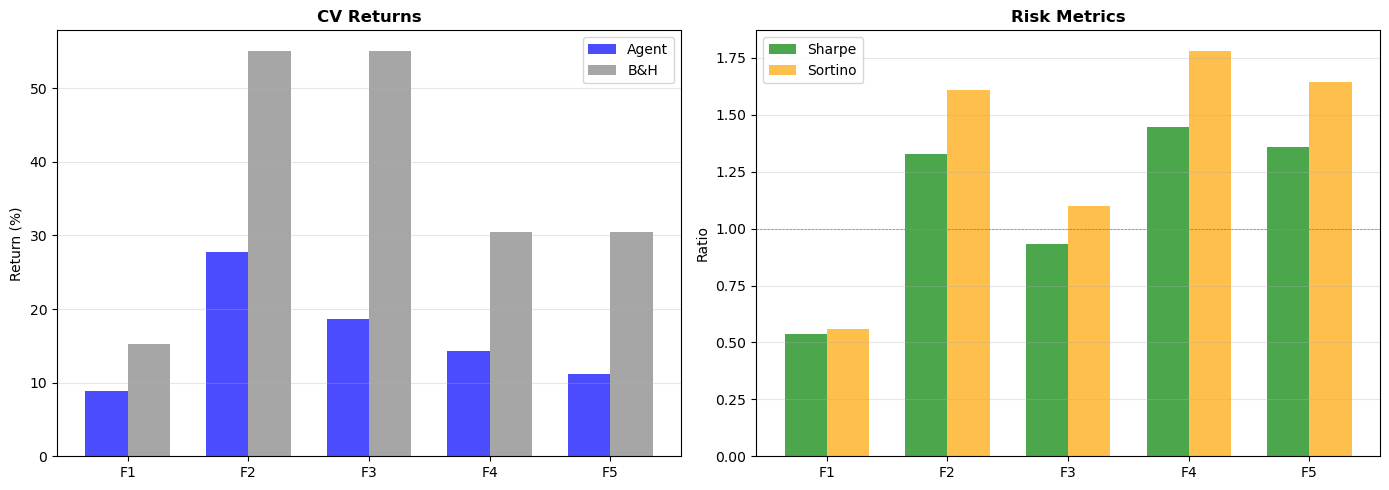

 Saved: /Users/ak/Desktop/spy_sac_v5/charts/2_cv_performance.png


In [9]:
# ==============================================================================
# CV RESULTS CHART
# ==============================================================================
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
x = np.arange(len(cv_df))
axes[0].bar(x - 0.175, cv_df['return'], 0.35, label='Agent', color='blue', alpha=0.7)
axes[0].bar(x + 0.175, cv_df['bh'], 0.35, label='B&H', color='gray', alpha=0.7)
axes[0].axhline(0, color='black', lw=0.5); axes[0].set_xticks(x); axes[0].set_xticklabels([f"F{i+1}" for i in range(len(cv_df))])
axes[0].set_ylabel('Return (%)'); axes[0].set_title('CV Returns', fontweight='bold'); axes[0].legend(); axes[0].grid(alpha=0.3, axis='y')

axes[1].bar(x - 0.175, cv_df['sharpe'], 0.35, label='Sharpe', color='green', alpha=0.7)
axes[1].bar(x + 0.175, cv_df['sortino'], 0.35, label='Sortino', color='orange', alpha=0.7)
axes[1].axhline(1, color='gray', ls='--', lw=0.5); axes[1].set_xticks(x); axes[1].set_xticklabels([f"F{i+1}" for i in range(len(cv_df))])
axes[1].set_ylabel('Ratio'); axes[1].set_title('Risk Metrics', fontweight='bold'); axes[1].legend(); axes[1].grid(alpha=0.3, axis='y')

plt.tight_layout(); plt.savefig(f"{CHARTS_PATH}2_cv_performance.png", dpi=150); plt.show()
print(f" Saved: {CHARTS_PATH}2_cv_performance.png")

In [10]:
# ==============================================================================
# FINAL MODEL TRAINING
# ==============================================================================
print("\n" + "="*60 + "\nFINAL MODEL TRAINING\n" + "="*60)
final_train = featured_data[:TRAIN_END]
print(f"Training: {len(final_train)} days | Steps: {FINAL_TIMESTEPS:,}")

final_env = DummyVecEnv([make_env(final_train[MARKET_FEATURES].values.astype(np.float32),
    final_train['Close_orig'].values.astype(np.float32), final_train['SH_orig'].values.astype(np.float32),
    final_train['VIX_raw'].values.astype(np.float32), final_train['MA50'].values.astype(np.float32),
    final_train['MA200'].values.astype(np.float32))])

start = time.time()
final_model = SAC("MlpPolicy", train_env, learning_rate=3e-4, batch_size=256, gamma=0.99, ent_coef='auto',
                tau=0.005, policy_kwargs={'net_arch': [256, 256]}, seed=SEED, verbose=1)
final_model.save(f"{MODELS_PATH}final_model.zip")
print(f"\n Training complete: {(time.time()-start)/60:.1f} min | Saved: {MODELS_PATH}final_model.zip")


FINAL MODEL TRAINING
Training: 2799 days | Steps: 750,000
Using cpu device

 Training complete: 0.0 min | Saved: /Users/ak/Desktop/spy_sac_v5/models/final_model.zip


In [11]:
# ==============================================================================
# OOS BACKTESTS
# ==============================================================================
print("\n" + "="*60 + "\nOUT-OF-SAMPLE BACKTESTS (2022-2025)\n" + "="*60)

oos_results = {}
for year, period in OOS_PERIODS.items():
    print(f"\n--- {year} ---")
    oos_df = featured_data[period[0]:period[1]]
    if len(oos_df) == 0: print(f"No data for {year}"); continue
    dates = oos_df.index.tolist()
    
    oos_env = DummyVecEnv([make_env(oos_df[MARKET_FEATURES].values.astype(np.float32),
        oos_df['Close_orig'].values.astype(np.float32), oos_df['SH_orig'].values.astype(np.float32),
        oos_df['VIX_raw'].values.astype(np.float32), oos_df['MA50'].values.astype(np.float32),
        oos_df['MA200'].values.astype(np.float32), dates=dates, log_trades=True)])
    
    info = evaluate(final_model, oos_env)
    bh = (oos_df['Close_orig'].iloc[-1] / oos_df['Close_orig'].iloc[0] - 1) * 100
    info.update({'year': year, 'period': f"{period[0]} to {period[1]}", 'bh_return': bh, 'alpha': info['total_return'] - bh,
                 'dates': dates, 'spy_prices': oos_df['Close_orig'].values})
    oos_results[year] = info
    print(f"Agent: {info['total_return']:+.2f}% | B&H: {bh:+.2f}% | Alpha: {info['alpha']:+.2f}%")
    print(f"Sharpe: {info['sharpe']:.3f} | Sortino: {info['sortino']:.3f} | Calmar: {info['calmar']:.3f} | MaxDD: {info['max_drawdown']:.2f}%")


OUT-OF-SAMPLE BACKTESTS (2022-2025)

--- 2022 ---
Agent: -12.63% | B&H: -18.65% | Alpha: +6.02%
Sharpe: -1.160 | Sortino: -1.670 | Calmar: -0.941 | MaxDD: 14.09%

--- 2023 ---
Agent: +16.03% | B&H: +26.71% | Alpha: -10.68%
Sharpe: 1.735 | Sortino: 2.839 | Calmar: 2.418 | MaxDD: 7.02%

--- 2024 ---
Agent: +15.59% | B&H: +25.59% | Alpha: -10.00%
Sharpe: 1.740 | Sortino: 2.178 | Calmar: 2.337 | MaxDD: 7.03%

--- 2025 ---
Agent: +6.46% | B&H: +17.85% | Alpha: -11.39%
Sharpe: 0.688 | Sortino: 0.795 | Calmar: 0.578 | MaxDD: 12.68%


In [12]:
# ==============================================================================
# SAVE TRADE LOGS & METRICS
# ==============================================================================
from pathlib import Path
import csv

print("\nSaving trade logs...")
Path(TRADES_PATH).mkdir(parents=True, exist_ok=True) 
Path(RESULTS_PATH).mkdir(parents=True, exist_ok=True)

# TRADE LOGS (fixed)
for year, result in oos_results.items():
    if result.get('trade_log'):
        trades_df = pd.DataFrame(result['trade_log'])
        trade_file = f"{TRADES_PATH}trades_{year}.csv"
        
        with open(trade_file, 'w', newline='', encoding='utf-8') as f:
            writer = csv.writer(f)
            writer.writerow(trades_df.columns)
            for row in trades_df.itertuples(index=False):
                writer.writerow(row)
        print(f" {trade_file}")

# METRICS (your version is fine)
oos_metrics = [{'year': y, 'total_return': r['total_return'], 'bh_return': r['bh_return'], 'alpha': r['alpha'],
                'sharpe': r['sharpe'], 'sortino': r['sortino'], 'calmar': r['calmar'], 'max_drawdown': r['max_drawdown'],
                'win_rate': r['win_rate']} for y, r in oos_results.items()]
oos_df = pd.DataFrame(oos_metrics)

metrics_file = os.path.join(RESULTS_PATH, "oos_metrics.csv")
with open(metrics_file, 'w', newline='', encoding='utf-8') as f:
    writer = csv.writer(f)
    writer.writerow(oos_df.columns)
    for row in oos_df.itertuples(index=False):
        writer.writerow(row)

print(f"\n {metrics_file}")
print("\nOOS Summary:")
print(oos_df.to_string(index=False))



Saving trade logs...
 /Users/ak/Desktop/spy_sac_v5/trades/trades_2022.csv
 /Users/ak/Desktop/spy_sac_v5/trades/trades_2023.csv
 /Users/ak/Desktop/spy_sac_v5/trades/trades_2024.csv
 /Users/ak/Desktop/spy_sac_v5/trades/trades_2025.csv

 /Users/ak/Desktop/spy_sac_v5/results/oos_metrics.csv

OOS Summary:
year  total_return  bh_return      alpha    sharpe   sortino    calmar  max_drawdown  win_rate
2022    -12.626837 -18.646399   6.019561 -1.160278 -1.670001 -0.941483     14.090521 44.117647
2023     16.033550  26.709220 -10.675670  1.735298  2.838963  2.417767      7.021325 55.882353
2024     15.587450  25.589299 -10.001849  1.740177  2.178323  2.336837      7.029875 59.832636
2025      6.464875  17.854574 -11.389699  0.687648  0.795031  0.578438     12.682002 57.657658


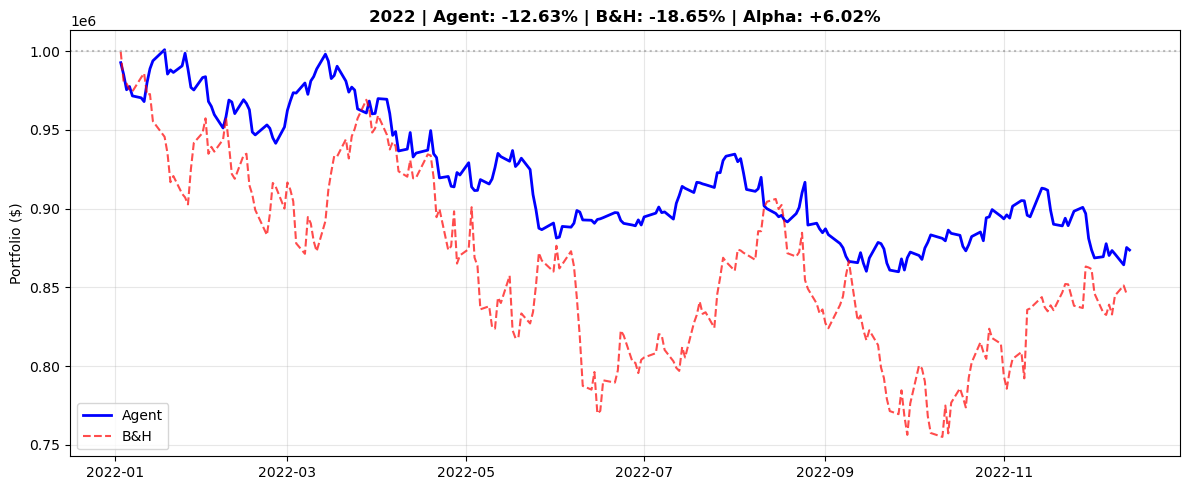

 /Users/ak/Desktop/spy_sac_v5/charts/3_oos_2022_equity.png


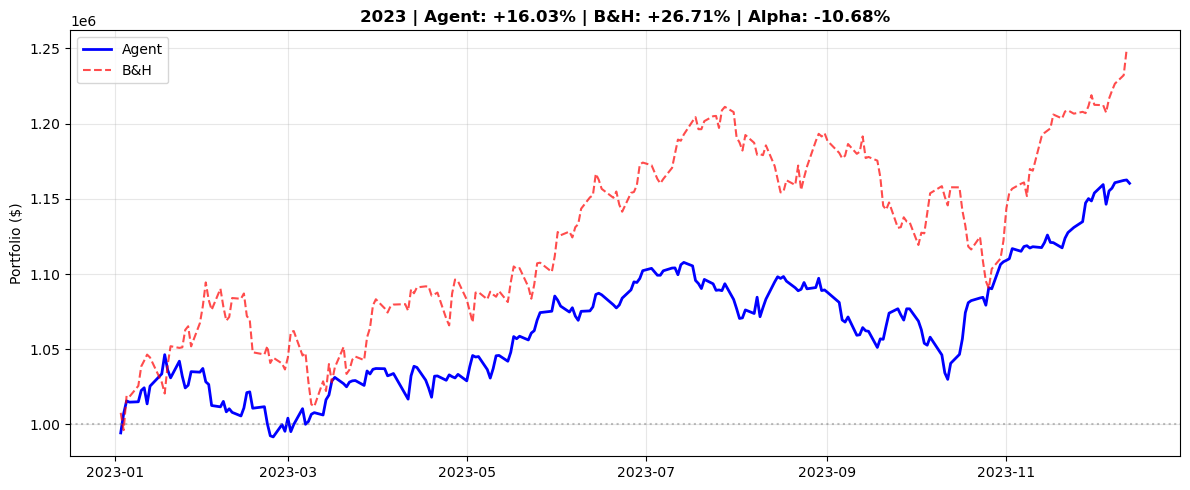

 /Users/ak/Desktop/spy_sac_v5/charts/4_oos_2023_equity.png


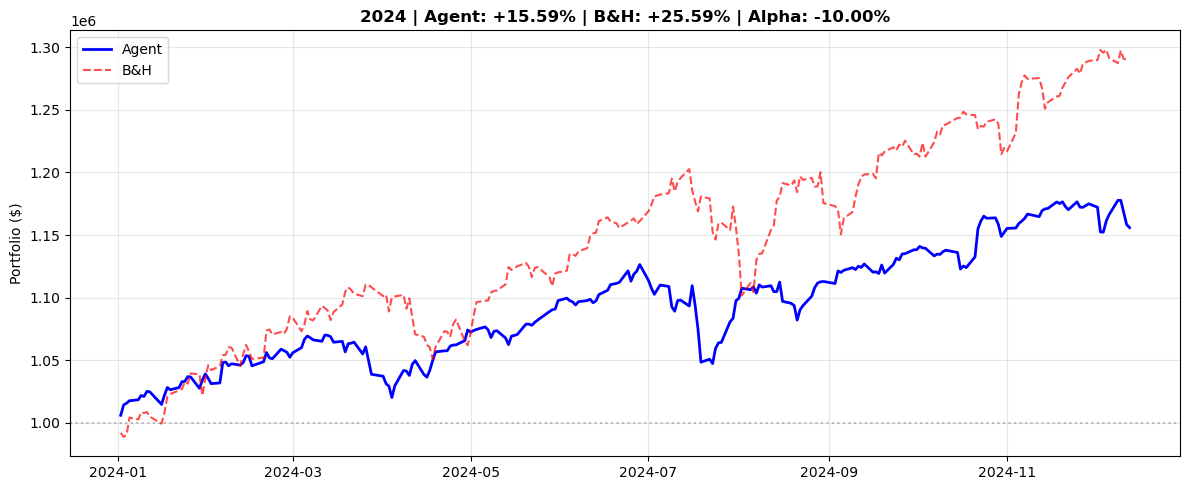

 /Users/ak/Desktop/spy_sac_v5/charts/5_oos_2024_equity.png


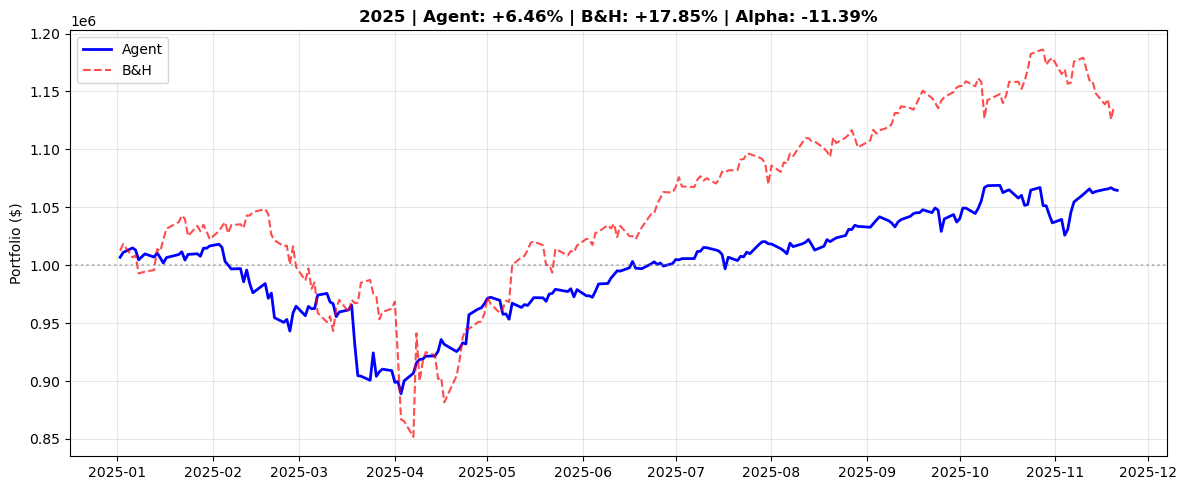

 /Users/ak/Desktop/spy_sac_v5/charts/6_oos_2025_equity.png


In [13]:
# ==============================================================================
# EQUITY CURVES (Individual Years)
# ==============================================================================
for i, (year, result) in enumerate(oos_results.items()):
    fig, ax = plt.subplots(figsize=(12, 5))
    ph = np.array(result['portfolio_history'])
    dates = pd.to_datetime(result['dates'])
    n = min(len(ph) - 1, len(dates))
    ax.plot(dates[:n], ph[1:n+1], 'b-', lw=2, label='Agent')
    spy = result['spy_prices'][:n]
    bh = INITIAL_CAPITAL * np.cumprod(np.r_[1.0, 1 + np.diff(spy)/spy[:-1]])
    ax.plot(dates[:len(bh)-1], bh[1:], 'r--', lw=1.5, alpha=0.7, label='B&H')
    ax.axhline(INITIAL_CAPITAL, color='gray', ls=':', alpha=0.5)
    ax.set_title(f"{year} | Agent: {result['total_return']:+.2f}% | B&H: {result['bh_return']:+.2f}% | Alpha: {result['alpha']:+.2f}%", fontweight='bold')
    ax.set_ylabel('Portfolio ($)'); ax.legend(); ax.grid(alpha=0.3)
    plt.tight_layout(); plt.savefig(f"{CHARTS_PATH}{3+i}_oos_{year}_equity.png", dpi=150); plt.show()
    print(f" {CHARTS_PATH}{3+i}_oos_{year}_equity.png")

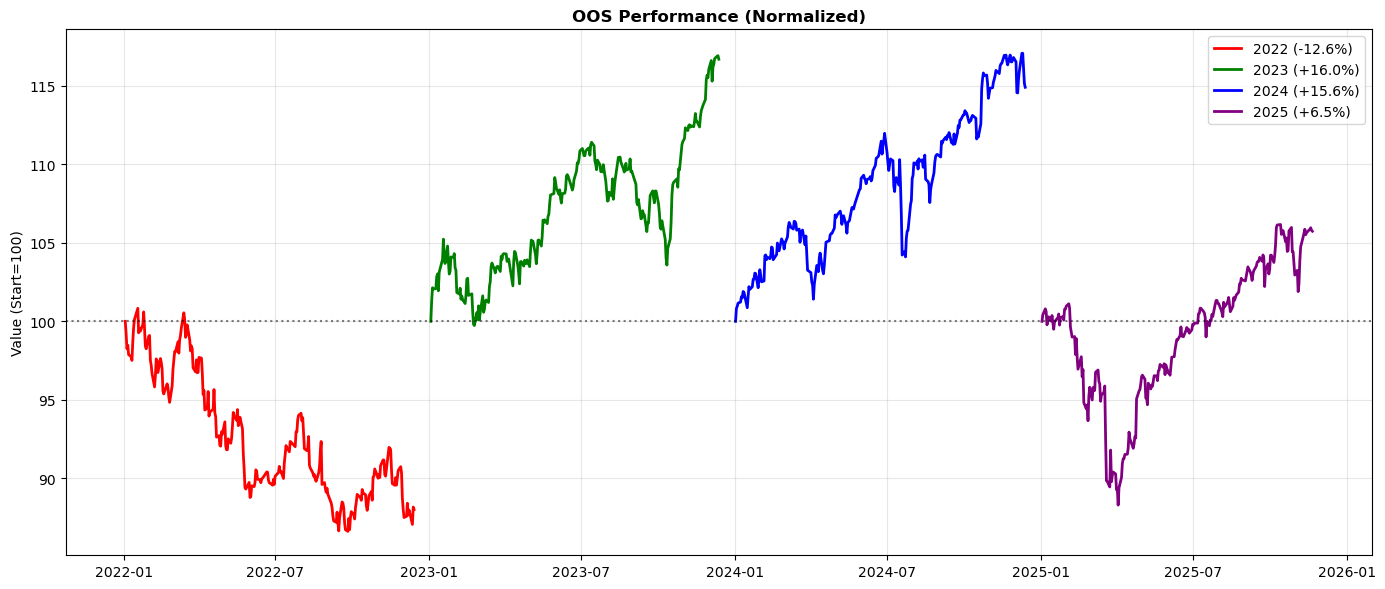

 /Users/ak/Desktop/spy_sac_v5/charts/7_oos_combined.png/pdf


In [14]:
# ==============================================================================
# COMBINED EQUITY CURVE
# ==============================================================================
fig, ax = plt.subplots(figsize=(14, 6))
colors = {'2022': 'red', '2023': 'green', '2024': 'blue', '2025': 'purple'}
for year, result in oos_results.items():
    ph = np.array(result['portfolio_history'])
    dates = pd.to_datetime(result['dates'])
    n = min(len(ph) - 1, len(dates))
    ax.plot(dates[:n], ph[1:n+1] / ph[1] * 100, lw=2, color=colors.get(year, 'gray'), label=f"{year} ({result['total_return']:+.1f}%)")
ax.axhline(100, color='black', ls=':', alpha=0.5)
ax.set_title('OOS Performance (Normalized)', fontweight='bold'); ax.set_ylabel('Value (Start=100)'); ax.legend(); ax.grid(alpha=0.3)
plt.tight_layout(); plt.savefig(f"{CHARTS_PATH}7_oos_combined.png", dpi=150); plt.savefig(f"{CHARTS_PATH}7_oos_combined.pdf"); plt.show()
print(f" {CHARTS_PATH}7_oos_combined.png/pdf")

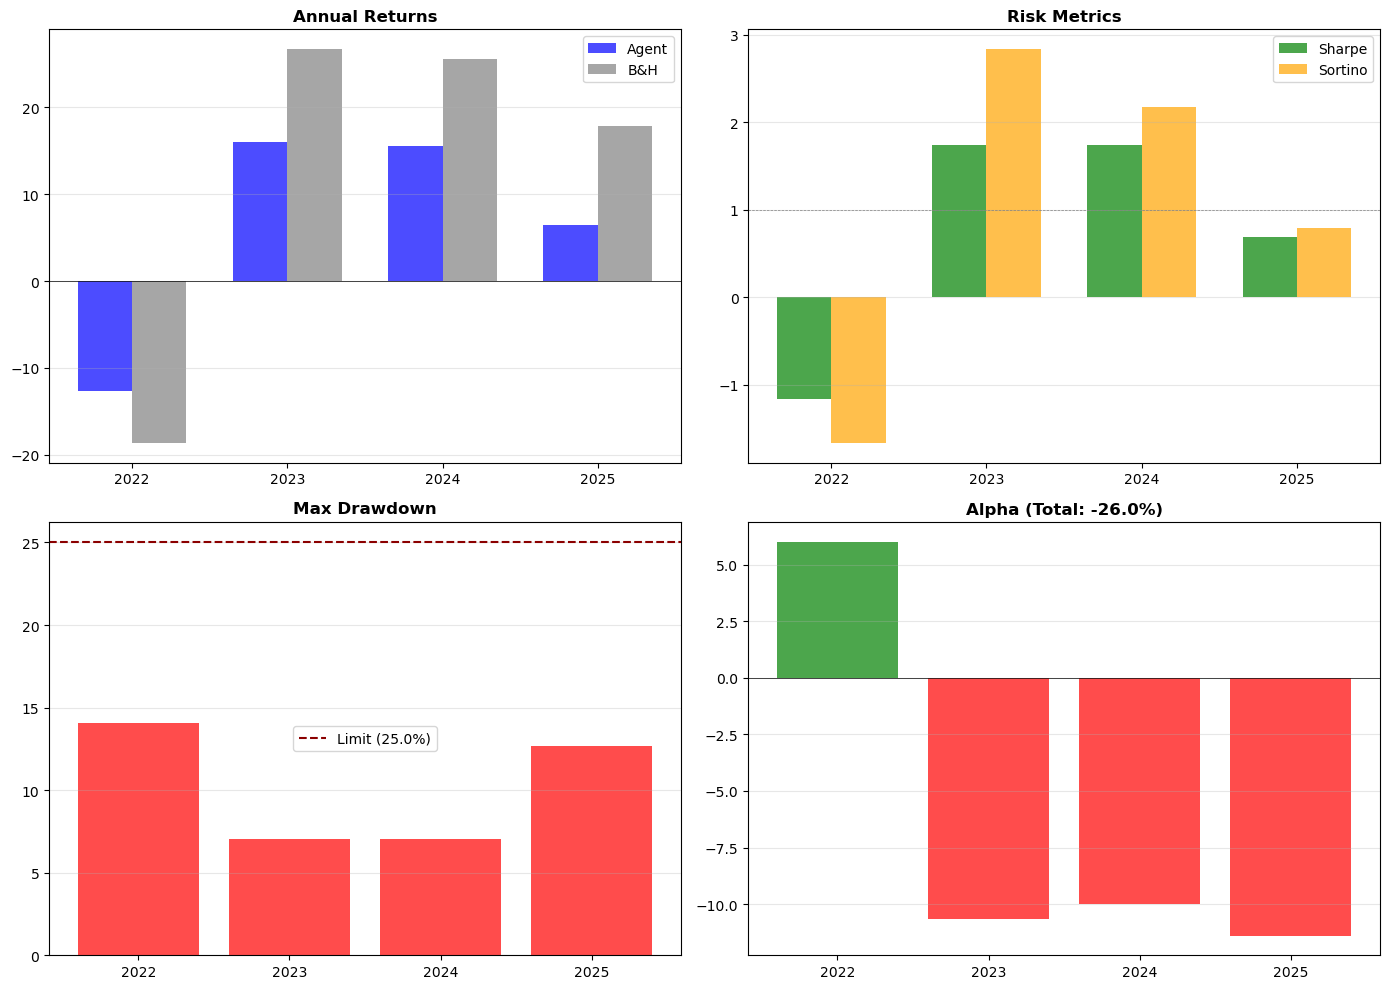

 /Users/ak/Desktop/spy_sac_v5/charts/8_summary.png/pdf


In [15]:
# ==============================================================================
# SUMMARY CHARTS
# ==============================================================================
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
years = list(oos_results.keys())
agent_rets = [oos_results[y]['total_return'] for y in years]
bh_rets = [oos_results[y]['bh_return'] for y in years]
alphas = [oos_results[y]['alpha'] for y in years]

x = np.arange(len(years))
axes[0,0].bar(x - 0.175, agent_rets, 0.35, label='Agent', color='blue', alpha=0.7)
axes[0,0].bar(x + 0.175, bh_rets, 0.35, label='B&H', color='gray', alpha=0.7)
axes[0,0].axhline(0, color='black', lw=0.5); axes[0,0].set_xticks(x); axes[0,0].set_xticklabels(years)
axes[0,0].set_title('Annual Returns', fontweight='bold'); axes[0,0].legend(); axes[0,0].grid(alpha=0.3, axis='y')

axes[0,1].bar(x - 0.175, [oos_results[y]['sharpe'] for y in years], 0.35, label='Sharpe', color='green', alpha=0.7)
axes[0,1].bar(x + 0.175, [oos_results[y]['sortino'] for y in years], 0.35, label='Sortino', color='orange', alpha=0.7)
axes[0,1].axhline(1, color='gray', ls='--', lw=0.5); axes[0,1].set_xticks(x); axes[0,1].set_xticklabels(years)
axes[0,1].set_title('Risk Metrics', fontweight='bold'); axes[0,1].legend(); axes[0,1].grid(alpha=0.3, axis='y')

axes[1,0].bar(years, [oos_results[y]['max_drawdown'] for y in years], color='red', alpha=0.7)
axes[1,0].axhline(MAX_DRAWDOWN_PCT * 100, color='darkred', ls='--', label=f'Limit ({MAX_DRAWDOWN_PCT*100}%)')
axes[1,0].set_title('Max Drawdown', fontweight='bold'); axes[1,0].legend(); axes[1,0].grid(alpha=0.3, axis='y')

axes[1,1].bar(years, alphas, color=['green' if a > 0 else 'red' for a in alphas], alpha=0.7)
axes[1,1].axhline(0, color='black', lw=0.5)
axes[1,1].set_title(f'Alpha (Total: {sum(alphas):+.1f}%)', fontweight='bold'); axes[1,1].grid(alpha=0.3, axis='y')

plt.tight_layout(); plt.savefig(f"{CHARTS_PATH}8_summary.png", dpi=150); plt.savefig(f"{CHARTS_PATH}8_summary.pdf"); plt.show()
print(f" {CHARTS_PATH}8_summary.png/pdf")

In [16]:
# ==============================================================================
# FINAL SUMMARY
# ==============================================================================
print("\n" + "="*70 + "\nV3 COMPLETE\n" + "="*70)
print(f"\n{'Year':<8} {'Agent':>10} {'B&H':>10} {'Alpha':>10} {'Sharpe':>8} {'Sortino':>8} {'MaxDD':>8}")
print("-"*70)
for y, r in oos_results.items():
    print(f"{y:<8} {r['total_return']:>+9.2f}% {r['bh_return']:>+9.2f}% {r['alpha']:>+9.2f}% {r['sharpe']:>8.3f} {r['sortino']:>8.3f} {r['max_drawdown']:>7.2f}%")
print("-"*70)
total_agent = sum(r['total_return'] for r in oos_results.values())
total_bh = sum(r['bh_return'] for r in oos_results.values())
print(f"{'TOTAL':<8} {total_agent:>+9.2f}% {total_bh:>+9.2f}% {total_agent-total_bh:>+9.2f}%")

print(f"\n Output: {SAVE_PATH}")
print(f"   Models: fold_1-5.zip, final_model.zip")
print(f"   Results: cv_fold_metrics.csv, oos_metrics.csv")
print(f"   Trades: trades_2022.csv, trades_2023.csv, trades_2024.csv, trades_2025.csv")
print(f"   Charts: 1-8_*.png/pdf")
print("\n" + "="*70)


V3 COMPLETE

Year          Agent        B&H      Alpha   Sharpe  Sortino    MaxDD
----------------------------------------------------------------------
2022        -12.63%    -18.65%     +6.02%   -1.160   -1.670   14.09%
2023        +16.03%    +26.71%    -10.68%    1.735    2.839    7.02%
2024        +15.59%    +25.59%    -10.00%    1.740    2.178    7.03%
2025         +6.46%    +17.85%    -11.39%    0.688    0.795   12.68%
----------------------------------------------------------------------
TOTAL       +25.46%    +51.51%    -26.05%

 Output: /Users/ak/Desktop/spy_sac_v5/
   Models: fold_1-5.zip, final_model.zip
   Results: cv_fold_metrics.csv, oos_metrics.csv
   Trades: trades_2022.csv, trades_2023.csv, trades_2024.csv, trades_2025.csv
   Charts: 1-8_*.png/pdf



In [17]:
# ==============================================================================
# LOAD MODEL (for future use)
# ==============================================================================
print("To load later:")
print(f"from stable_baselines3 import SAC")
print(f"model = SAC.load('{MODELS_PATH}final_model.zip')")
print("action, _ = model.predict(observation, deterministic=True)")

To load later:
from stable_baselines3 import SAC
model = SAC.load('/Users/ak/Desktop/spy_sac_v5/models/final_model.zip')
action, _ = model.predict(observation, deterministic=True)
